<center>
    <span style="color: #2E86C1; font-size: 3em;">
        Training Model
    </span>
</center>

# **Nội dung notebook**

Notebook này được xây dựng nhằm thực hiện các bước tiền xử lý và huấn luyện mô hình dự đoán cho tập dữ liệu đầu vào, với mục tiêu chính là xây dựng một mô hình hiệu quả và đánh giá chất lượng dự đoán thông qua các công đoạn:

- Tiền xử lý dữ liệu: làm sạch, xử lý giá trị thiếu, và tạo đặc trưng phù hợp để phục vụ huấn luyện.

- Chuẩn hóa và mã hóa các đặc trưng theo yêu cầu mô hình.

- Chia dữ liệu thành tập huấn luyện và kiểm tra.

- Xây dựng, huấn luyện và tinh chỉnh mô hình dự đoán.

- Đánh giá hiệu suất mô hình trên tập kiểm tra thông qua các chỉ số phù hợp.

- Lưu mô hình và xuất kết quả dự đoán phục vụ cho bước nộp bài/submission.

**Mô hình lựa chọn**  
XGBoost được lựa chọn vì hiệu suất cao, khả năng xử lý tốt dữ liệu phức tạp, có cơ chế chống overfitting nhờ regularization, tốc độ huấn luyện nhanh và dễ tinh chỉnh siêu tham số.

# **Thư viện hỗ trợ**

## **Tải các thư viện hỗ trợ**

In [44]:
!pip install -q gdown

In [45]:
import gdown
requirement_id = "1NOsUiX2kn34Ni9sI5zyImo4AIHkBrnmn"
gdown.download(f"https://drive.google.com/uc?id={requirement_id}", "requirements.txt", quiet=True)

'requirements.txt'

In [46]:
!pip install -r requirements.txt -q

## **Import các thư viện hỗ trợ**

In [47]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize_scalar
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBRegressor

import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from kneed import KneeLocator
from google.colab import files
import matplotlib.pyplot as plt

## **Chuẩn bị cấu trúc thư mục**

In [48]:
data_folder='/content/Dataset'
model_folder = "/content/Model"
submission_folder = "/content/Submission"

os.makedirs(data_folder, exist_ok=True)
os.makedirs(model_folder, exist_ok=True)
os.makedirs(submission_folder, exist_ok=True)

pd.set_option('display.max_columns', None)

- Upload file dữ liệu

In [ ]:
if not ((os.path.exists(os.path.join(data_folder, 'new_train.csv'))) and (os.path.exists(os.path.join(data_folder, 'new_test.csv')))):

  train_id = '1OCPwLu4fMinX7EpvJQHb1EVelgbZrZfG'
  test_id = '16V7LSWpVd__qbbY5oAz0RMOlC9uXlSQX'

  gdown.download(f"https://drive.google.com/uc?id={train_id}", os.path.join(data_folder, "new_train.csv"), quiet=True)
  gdown.download(f"https://drive.google.com/uc?id={test_id}", os.path.join(data_folder, "new_test.csv"), quiet=True)

#   Mở comment dưới này để tự upload các file new_train.csv và new_test.csv có được từ Preprocess.ipynb
#   uploaded = files.upload()

#   for filename in uploaded.keys():
#       os.rename(filename, os.path.join(data_folder, filename)) 

- Tải model pretrained (comment lại đoạn code bên dưới nếu muốn train lại từ đầu)

In [50]:
model0_id = '17ckrgrx7e4PqHD4Lq4b8ZnCOBG78J-b3'
model1_id = '1vdrVQcOSUu1FzE6FC7ZIyBDE-OnAcnjo'
gdown.download(f"https://drive.google.com/uc?id={model0_id}", os.path.join(model_folder, "model0.pkl"), quiet=True)
gdown.download(f"https://drive.google.com/uc?id={model1_id}", os.path.join(model_folder, "model1.pkl"), quiet=True)

'/content/Model/model1.pkl'

## **Đọc dữ liệu**

In [51]:
train_path = os.path.join(data_folder, 'new_train.csv')
test_path = os.path.join(data_folder, 'new_test.csv')

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# **Tiền xử lí dữ liệu cho mô hình**

## **Khám phá tổng quan**

- Ta kiểm tra kiểu dữ liệu của các đặc trưng trong `train_data`

In [52]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 43 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   sale_price       200000 non-null  int64  
 1   sale_nbr         200000 non-null  float64
 2   join_status      200000 non-null  object 
 3   imp_val          200000 non-null  int64  
 4   year_built       200000 non-null  int64  
 5   year_reno        200000 non-null  float64
 6   sqft_lot         200000 non-null  int64  
 7   grade            200000 non-null  int64  
 8   fbsmt_grade      200000 non-null  int64  
 9   condition        200000 non-null  int64  
 10  stories          200000 non-null  float64
 11  beds             200000 non-null  int64  
 12  bath_full        200000 non-null  int64  
 13  bath_3qtr        200000 non-null  int64  
 14  bath_half        200000 non-null  int64  
 15  garb_sqft        200000 non-null  float64
 16  gara_sqft        200000 non-null  floa

- Ta thấy các đặc trưng `submarket`, `join_status` có kiểu dữ liệu là object.

- Do chúng ta sử dụng mô hình `xgboost` nên các đặc trưng phải là numeric, vì vậy ta phải tiến hành xử lí dữ liệu.

## **Đặc trưng `submarket`**

In [53]:
train_data['submarket'].unique()

array(['I', 'Q', 'K', 'G', 'P', 'B', 'D', 'O', 'L', 'R', 'J', 'N', 'E',
       'M', 'A', 'F', nan, 'H', 'C', 'S'], dtype=object)

- Qua kiểm tra, ta thấy đặc trưng `submarket` có rất nhiều giá trị đặc trưng, do đó để tiện xử lí ta sẽ sử dụng biện pháp phân cụm các giá trị này dựa trên giá trị đất trên $m^2$.

Optimal number of clusters (k): 4


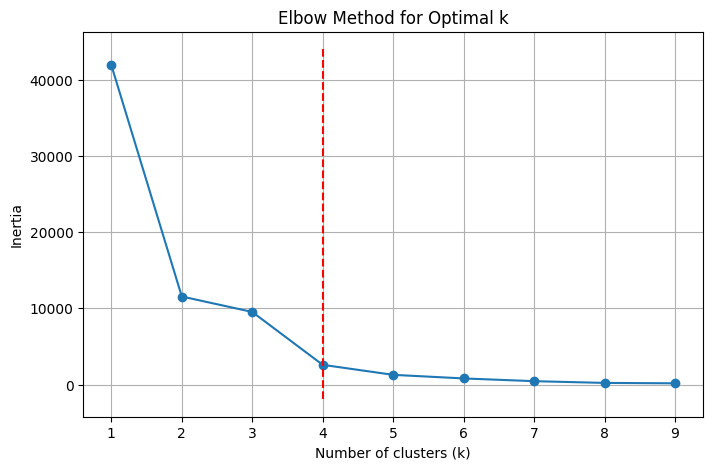

In [54]:
# Tính val_per_sqft trung bình theo submarket
submarket_avg = train_data.groupby("submarket")["val_per_sqft"].mean().reset_index()

# reshape thành mảng 2D để fit cho KMeans
X = submarket_avg["val_per_sqft"].values.reshape(-1, 1)

# Thử nhiều giá trị k (cụm) và tính inertia
inertias = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Dùng KneeLocator để tìm điểm gấp (elbow)
knee = KneeLocator(K_range, inertias, curve='convex', direction='decreasing')
optimal_k = knee.knee
print("Optimal number of clusters (k):", optimal_k)

# Vẽ biểu đồ elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

In [55]:
# Áp dụng KMeans với số cụm tối ưu
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
submarket_avg["cluster"] = kmeans.fit_predict(X)

In [56]:
# Tạo map: submarket → cluster
cluster_map = dict(zip(submarket_avg["submarket"], submarket_avg["cluster"]))

# Thêm cột mới vào train_data
train_data["submarket_cluster"] = train_data["submarket"].map(cluster_map)
test_data["submarket_cluster"] = test_data["submarket"].map(cluster_map)

- Sau khi đã phân cụm các `submarket`, ta tiến hành kiểm tra tính thứ tự của chúng. Do mô hình xgboost chịu ảnh hưởng bởi thứ tự rất mạnh, nên sau khi phân cụm chúng bằng cách sử dụng các giá trị số thì ta cần đảm bảo chúng đảm bảo tính thứ tự.

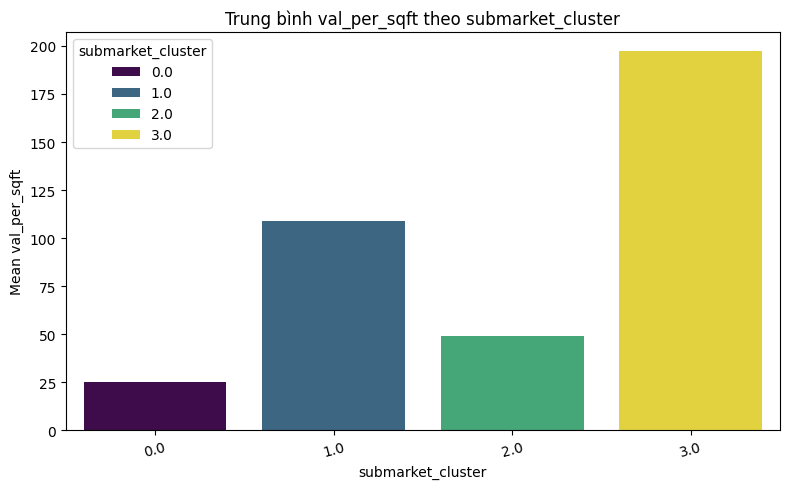

In [57]:
# Tính giá trị trung bình của val_per_sqft theo submarket_cluster
avg_val_per_submarket = (
    train_data.groupby("submarket_cluster")["val_per_sqft"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_val_per_submarket, x="submarket_cluster", y="val_per_sqft", palette="viridis", hue="submarket_cluster")

plt.title("Trung bình val_per_sqft theo submarket_cluster")
plt.xlabel("submarket_cluster")
plt.ylabel("Mean val_per_sqft")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


- Như ta có thể thấy, các giá trị hiện nay không đảm bảo tính thứ tự. Do đó ta sẽ tiến hành sắp xếp lại chúng.

In [58]:
# Tạo map từ cluster ban đầu → rank mới (0 là thấp nhất)
n_clusters = len(avg_val_per_submarket)
submarket_rank_map = {cluster: n_clusters - 1 - rank for rank, cluster in enumerate(avg_val_per_submarket["submarket_cluster"])}

# Gán lại cột mới
train_data["submarket_cluster"] = train_data["submarket_cluster"].map(submarket_rank_map)
test_data["submarket_cluster"] = test_data["submarket_cluster"].map(submarket_rank_map)

- Ta tiến hành kiểm tra lại xem chúng đã đúng thứ tự chưa

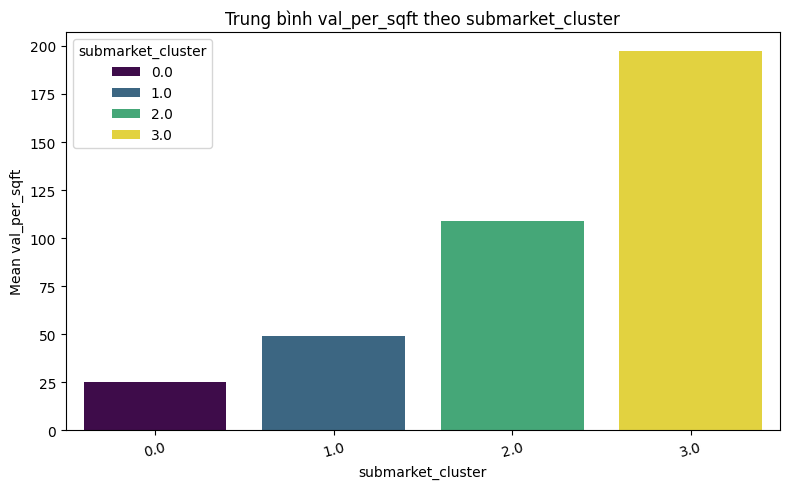

In [59]:
# Tính giá trị trung bình của val_per_sqft theo submarket_cluster
avg_val_per_submarket = (
    train_data.groupby("submarket_cluster")["val_per_sqft"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_val_per_submarket, x="submarket_cluster", y="val_per_sqft", palette="viridis", hue="submarket_cluster")

plt.title("Trung bình val_per_sqft theo submarket_cluster")
plt.xlabel("submarket_cluster")
plt.ylabel("Mean val_per_sqft")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

- Sau khi kiểm tra lại, ta thấy các giá trị đã đảm bảo tính thứ tụ.

## **Đặc trưng `join_status`**

In [60]:
train_data['join_status'].unique()

array(['nochg', 'reno - before', 'new', 'rebuilt - before'], dtype=object)

- Ta thấy `join_status` không có nhiều giá trị đặc trưng như `submarket`. Ta tiến hành kiểm tra thử xem các giá trị này có tính thứ tự không.

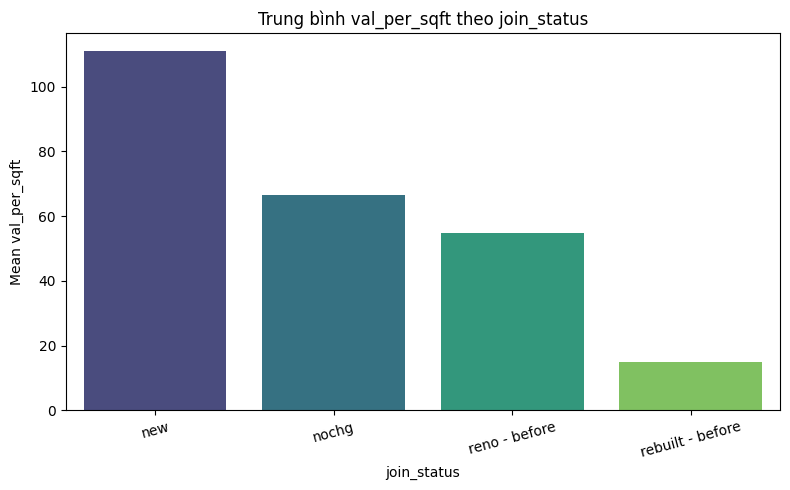

In [61]:
# Tính giá trị trung bình của val_per_sqft theo join_status
avg_val_per_status = (
    train_data.groupby("join_status")["val_per_sqft"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_val_per_status, x="join_status", y="val_per_sqft", palette="viridis", hue="join_status")

plt.title("Trung bình val_per_sqft theo join_status")
plt.xlabel("join_status")
plt.ylabel("Mean val_per_sqft")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

- Các giá trị đặc trưng trong `join_status` có tính thứ tự, hơn nữa còn có độ phân hóa khá tốt. Ta chỉ cần map các giá trị này lại là được.

In [62]:
# Tạo map từ join_status → giá trị số
status_map = {
    'nochg': 2,
    'reno - before': 1,
    'rebuilt - before': 0,
    'new': 3
}

# Gán lại cột mới
train_data['join_status_encoded'] = train_data['join_status'].map(status_map)
test_data['join_status_encoded'] = test_data['join_status'].map(status_map)

- Ta tiến hành kiểm tra lại coi đã đúng thứ tự chưa.

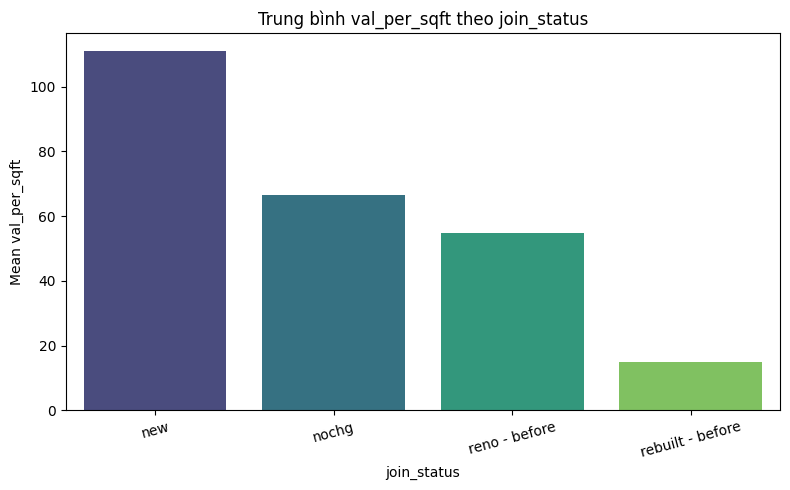

In [63]:
# Tính giá trị trung bình của val_per_sqft theo join_status
avg_val_per_status = (
    train_data.groupby("join_status")["val_per_sqft"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_val_per_status, x="join_status", y="val_per_sqft", palette="viridis", hue="join_status")

plt.title("Trung bình val_per_sqft theo join_status")
plt.xlabel("join_status")
plt.ylabel("Mean val_per_sqft")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## **Đặc trưng `hotzone_cluster`**

- Ta tiến hành kiểm tra lại các đặc trưng ta tạo trong quá trình tiền xử lí dữ liệu xem chúng đã đúng thứ tự chưa.

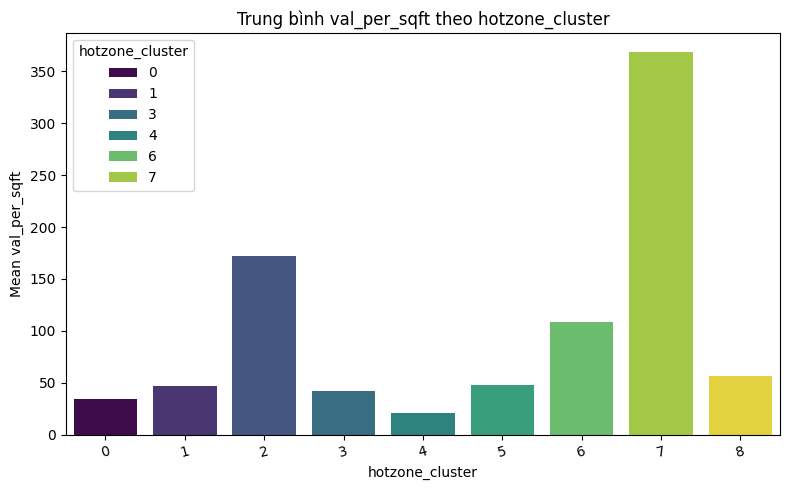

In [64]:
# Tính giá trị trung bình của val_per_sqft theo hotzone_cluster
avg_val_per_hotzone = (
    train_data.groupby("hotzone_cluster")["val_per_sqft"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_val_per_hotzone, x="hotzone_cluster", y="val_per_sqft", palette="viridis", hue="hotzone_cluster")

plt.title("Trung bình val_per_sqft theo hotzone_cluster")
plt.xlabel("hotzone_cluster")
plt.ylabel("Mean val_per_sqft")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

- Ta thấy chúng vẫn chưa được sắp xếp đúng thứ tự, do đó ta tiến hành sắp xếp lại chúng.

In [65]:
# Tạo map từ cluster ban đầu → rank mới (0 là thấp nhất)
n_clusters = len(avg_val_per_hotzone)
hotzone_rank_map = {cluster: n_clusters - 1 - rank for rank, cluster in enumerate(avg_val_per_hotzone["hotzone_cluster"])}

# Gán lại cột mới
train_data["hotzone_cluster"] = train_data["hotzone_cluster"].map(hotzone_rank_map)
test_data["hotzone_cluster"] = test_data["hotzone_cluster"].map(hotzone_rank_map)

- Ta tiến hành kiểm tra lại coi đã đúng thứ tự chưa.

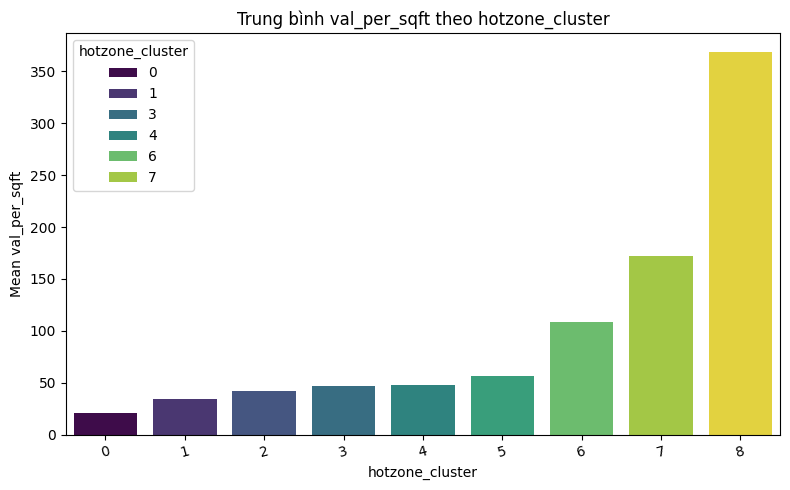

In [66]:
# Tính giá trị trung bình của val_per_sqft theo hotzone_cluster
avg_val_per_hotzone = (
    train_data.groupby("hotzone_cluster")["val_per_sqft"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_val_per_hotzone, x="hotzone_cluster", y="val_per_sqft", palette="viridis", hue="hotzone_cluster")

plt.title("Trung bình val_per_sqft theo hotzone_cluster")
plt.xlabel("hotzone_cluster")
plt.ylabel("Mean val_per_sqft")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## **Đặc trưng `zoning_cluster`**

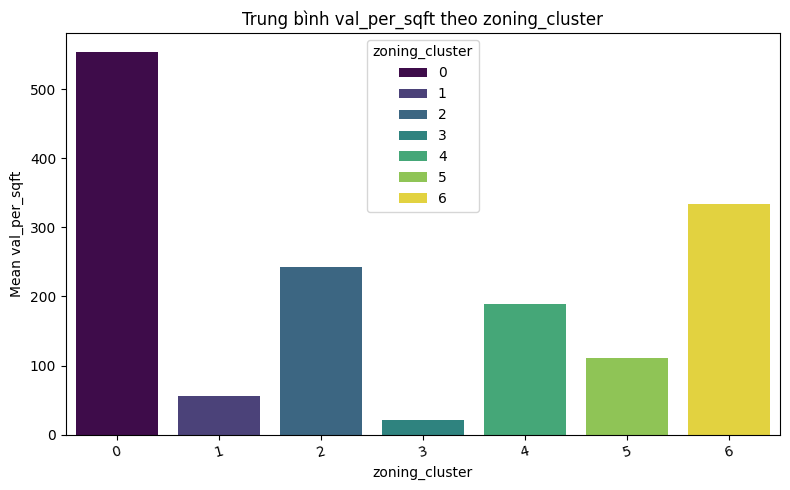

In [67]:
# Tính giá trị trung bình của val_per_sqft theo zoning_cluster
avg_val_per_zoning = (
    train_data.groupby("zoning_cluster")["val_per_sqft"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_val_per_zoning, x="zoning_cluster", y="val_per_sqft", palette="viridis", hue="zoning_cluster")

plt.title("Trung bình val_per_sqft theo zoning_cluster")
plt.xlabel("zoning_cluster")
plt.ylabel("Mean val_per_sqft")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

- Ta tiến hành sắp xếp lại thứ tự cho chúng.

In [68]:
# Tạo map từ cluster ban đầu → rank mới (0 là thấp nhất)
n_clusters = len(avg_val_per_zoning)
zoning_rank_map = {cluster: n_clusters - 1 - rank for rank, cluster in enumerate(avg_val_per_zoning["zoning_cluster"])}

# Gán lại cột mới
train_data["zoning_cluster"] = train_data["zoning_cluster"].map(zoning_rank_map)
test_data["zoning_cluster"] = test_data["zoning_cluster"].map(zoning_rank_map)

- Ta tiến hành kiểm tra lại coi đã đúng thứ tự chưa.

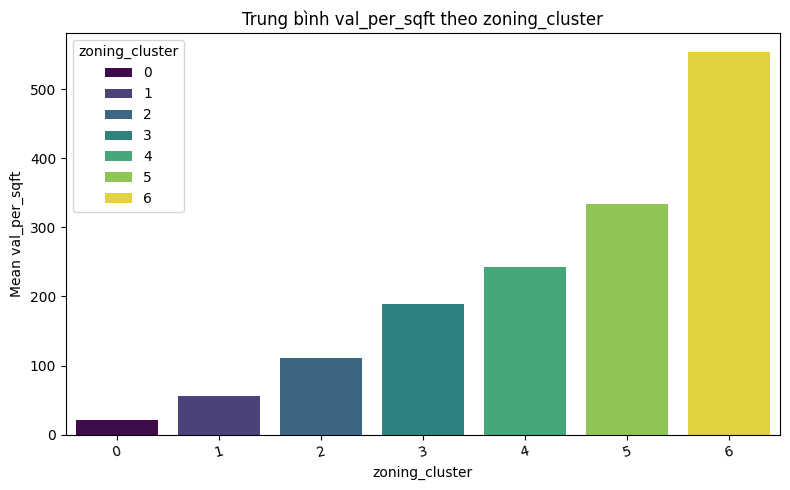

In [69]:
# Tính giá trị trung bình của val_per_sqft theo zoning_cluster
avg_val_per_zoning = (
    train_data.groupby("zoning_cluster")["val_per_sqft"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_val_per_zoning, x="zoning_cluster", y="val_per_sqft", palette="viridis", hue="zoning_cluster")

plt.title("Trung bình val_per_sqft theo zoning_cluster")
plt.xlabel("zoning_cluster")
plt.ylabel("Mean val_per_sqft")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## Đặc trưng `sale_year`, `sale_month`, `sale_day`

- Hiện giờ mô hình đang phải huấn luyện với quá nhiều đặc trưng, do đó ta sẽ tiến hành feature engineer lại 3 đặc trưng thời gian này thành 1 đặc trưng có ý nghĩa tốt hơn, đó là `months_since_first_sale`.

Lí do:

- `months_since_first_sale` là một biến liên tục duy nhất, phản ánh mức độ "cũ/mới" của giao dịch.

- Trong khi đó, `sale_year`, `sale_month`, `sale_day` là ba biến rời rạc, không có liên kết trực tiếp nào rõ ràng nếu không được mô hình hóa cẩn thận.

- Việc chia nhỏ này khiến mô hình khó hiểu được "khoảng cách thời gian thực sự" giữa các điểm dữ liệu.

> VD: (`sale_year` = 2015, `sale_month` = 12) và (`sale_year` = 2016, `sale_month` = 1) là liền kề nhau theo thời gian (cách nhau 1 tháng), nhưng mô hình có thể thấy chúng khác biệt xa nếu tách riêng từng cột. Vì mô hình chỉ thấy các số có sự khác nhau rõ ràng chứ không hiểu được chúng liền kề nhau.

In [70]:
first_year = train_data['sale_year'].min()
first_month = train_data[train_data['sale_year'] == first_year]['sale_month'].min()

train_data['months_since_first_sale'] = (
    (train_data['sale_year'] - first_year) * 12 +
    (train_data['sale_month'] - first_month)
)

In [71]:
first_year = test_data['sale_year'].min()
first_month = test_data[test_data['sale_year'] == first_year]['sale_month'].min()

test_data['months_since_first_sale'] = (
    (test_data['sale_year'] - first_year) * 12 +
    (test_data['sale_month'] - first_month)
)

## **Đặc trưng `sale_price`**

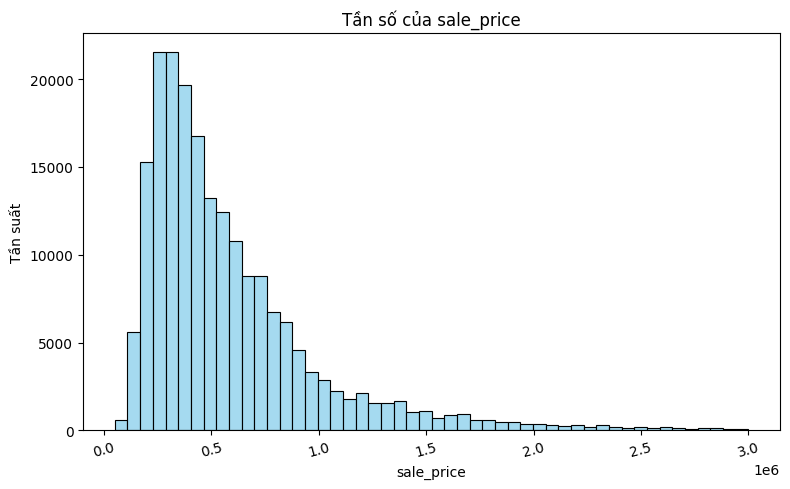

In [72]:
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
sns.histplot(train_data["sale_price"], bins=50, kde=False, color='skyblue')

plt.title("Tần số của sale_price")
plt.xlabel("sale_price")
plt.ylabel("Tần suất")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

- Dữ liệu `sale_price` thể hiện sự phân phối lệch phải rõ rệt (right-skewed), nghĩa là có rất nhiều ngôi nhà được bán ở mức giá thấp, trong khi một số ít ngôi nhà có giá rất cao gây ra đuôi dài về phía bên phải.

- Giải pháp:

    - Áp dụng log-transform giúp:

    - Nén các giá trị cao (outliers) để dữ liệu trở nên phân phối gần chuẩn hơn.

    - Giảm độ lệch, giúp các mô hình học tốt hơn.

    - Tăng độ ổn định của mô hình, giảm sai số dự đoán với các giá trị bất thường.

In [73]:
X = train_data.drop(columns=["sale_price"])
y_real = train_data["sale_price"]
y_log = np.log1p(y_real)

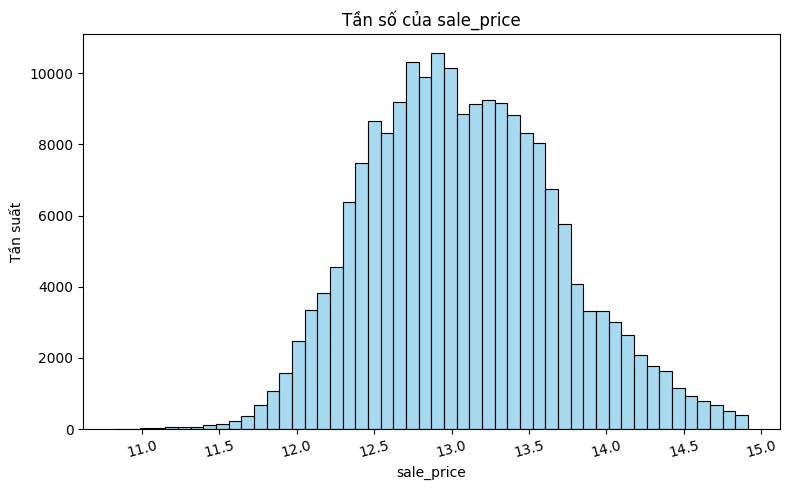

In [74]:
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
sns.histplot(y_log, bins=50, kde=False, color='skyblue')

plt.title("Tần số của sale_price")
plt.xlabel("sale_price")
plt.ylabel("Tần suất")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

- Như vậy `sale_price` đã gần với phân phối chuẩn hơn.

## Tổng kết

| Cột bị loại bỏ | Lí do |
| -------------- | ----- |
| `submarket`    | Đã được phân cụm thành `submarket_cluster` |
| `join_status`  | Đã được chuyển thành `join_status_encoded` |
| `sale_day`     | Quá chi tiết, không cần thiết |
| `sale_month`   | Đã được dùng để chuyền thành `months_since_first_sale` |
| `sale_year`    | Đã được dùng để chuyền thành `months_since_first_sale` |

In [75]:
drop_cols = ['submarket', 'join_status', 'sale_day', 'sale_month', 'sale_year']
train_data.drop(columns=drop_cols, inplace=True)
test_data.drop(columns=drop_cols, inplace=True)

In [76]:
train_data.columns

Index(['sale_price', 'sale_nbr', 'imp_val', 'year_built', 'year_reno',
       'sqft_lot', 'grade', 'fbsmt_grade', 'condition', 'stories', 'beds',
       'bath_full', 'bath_3qtr', 'bath_half', 'garb_sqft', 'gara_sqft', 'wfnt',
       'golf', 'greenbelt', 'noise_traffic', 'view_rainier', 'view_skyline',
       'view_lakesamm', 'view_otherwater', 'view_other', 'val_per_sqft',
       'hotzone_cluster', 'zoning_cluster', 'has_reno', 'has_basement',
       'is_residential', 'area_mod', 'log_sqft', 'log_sqft_1',
       'log_sqft_fbsmt', 'total_bath', 'view_west_combo', 'view_east_combo',
       'submarket_cluster', 'join_status_encoded', 'months_since_first_sale'],
      dtype='object')

# **Chuẩn bị mô hình**

## **Train**

- Chuẩn bị hàm winkler để validation và tunning

In [77]:
# ==== HÀM WINKLER SCORE ====
def winkler_score(y_true, lower, upper, alpha=0.1):
    """
    Tính Winkler Score cho một tập dữ liệu dự đoán.
    Args:
        y_true (np.array): Giá trị thực tế.
        lower (np.array): Giới hạn dưới của khoảng dự đoán.
        upper (np.array): Giới hạn trên của khoảng dự đoán.
        alpha (float): Hệ số điều chỉnh cho hình phạt ngoài khoảng.
    Returns:
        float: Giá trị Winkler Score trung bình.
    """
    width = upper - lower
    penalty = np.where(
        y_true < lower,
        (2 / alpha) * (lower - y_true),
        np.where(y_true > upper, (2 / alpha) * (y_true - upper), 0)
    )
    return np.mean(width + penalty)

# ==== HÀM TỐI ƯU GAMMA ====
def optimize_gamma(y_true, mu_log, predicted_error):
    """
    Tối ưu hóa giá trị gamma để giảm Winkler Score.
    Args:
        y_true (np.array): Giá trị thực tế.
        mu_log (np.array): Giá trị log của dự đoán trung bình.
        predicted_error (np.array): Sai số dự đoán.
    Returns:
        float: Giá trị gamma tối ưu.
    """
    def objective(gamma):
        lower = np.expm1(mu_log - gamma * np.sqrt(predicted_error))
        upper = np.expm1(mu_log + gamma * np.sqrt(predicted_error))
        return winkler_score(y_true, lower, upper)

    result = minimize_scalar(objective, bounds=(0.1, 5), method='bounded')
    return result.x

- Chuẩn bị dữ liệu huấn luyện, xác nhận

In [78]:
# ==== CHUẨN BỊ DỮ LIỆU ====
X_train, X_val, y_train_log, y_val_log, y_train_real, y_val_real = train_test_split(
    X, y_log, y_real, test_size=0.2, random_state=42
)

**Cách tiếp cận: Mô hình hai giai đoạn (Two-Stage Model)**

Phương pháp này dựa trên một ý tưởng đơn giản nhưng cực kỳ hiệu quả: chia bài toán thành hai giai đoạn riêng biệt để vừa dự đoán giá trị trung bình, vừa ước lượng được độ không chắc chắn trong dự đoán.

**Giai đoạn 1: Dự đoán giá trị trung tâm (model0)**

- Chúng ta sử dụng mô hình hồi quy mạnh như XGBoost hoặc LightGBM để dự đoán giá trị trung bình của sale_price.

- Đây là bước dự đoán như bình thường, cho ra dự đoán điểm (point prediction) – gọi là center_prediction.

**Giai đoạn 2: Dự đoán sai số bình phương (model1)**

- Tại bước này, ta tạo một mô hình thứ hai có nhiệm vụ học độ không chắc chắn trong dự đoán.

- Cụ thể, mô hình này sẽ dự đoán giá trị (y_thật - y_dự đoán)², tức là sai số bình phương.

- Mô hình model1 học được độ lớn sai số từ các đặc trưng đầu vào → giúp mô hình thích ứng với heteroscedasticity (sai số thay đổi theo từng loại nhà đất khác nhau).

**Xây dựng khoảng dự đoán**

Khi đã có center_prediction và predicted_error, ta tính khoảng dự đoán theo công thức:

$[ center_prediction - \gamma * \sqrt{predicted\_error}, center_prediction + \gamma * \sqrt{predicted\_error} ]$

- $\sqrt{predicted\_error}$ là độ lệch chuẩn ước tính từ sai số bình phương.

- $\gamma$ (gamma) là hệ số điều chỉnh độ rộng của khoảng.

- $\gamma$ được tối ưu tự động sao cho đạt Winkler Score thấp nhất, đây là tiêu chí chấm điểm của cuộc thi.

In [79]:
def load_or_train_model(model_paths=['model0.pkl', 'model1.pkl'], model_folder="../Model"):
    """
    Tải mô hình đã huấn luyện hoặc huấn luyện mới nếu không tìm thấy.
    Args:
        model_paths (list): Danh sách tên file mô hình.
        model_folder (str): Thư mục chứa mô hình.
    Returns:
        tuple: Trả về hai mô hình đã huấn luyện và giá trị dự đoán log trên tập validation.
    """

    # Lấy đường dân đầy đủ của các model
    model0_path = os.path.join(model_folder, model_paths[0])
    model1_path = os.path.join(model_folder, model_paths[1])

    # Nếu cả 2 model đã tồn tại thì load
    if os.path.exists(model0_path) and os.path.exists(model1_path):
        print(f"Loading models from {model0_path} and {model1_path}")
        model0 = joblib.load(model0_path)
        model1 = joblib.load(model1_path)
        mu_log_val = model0.predict(X_val)
        return model0, model1, mu_log_val

    print("Training new models...")
    # ==== TIỀN XỬ LÝ ====
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), X.columns)
    ])

    # ==== MODEL 0: GRIDSEARCH DỰ ĐOÁN GIÁ ====
    pipe0 = Pipeline([
        ("preprocessor", preprocessor),
        ("xgb", XGBRegressor(
                    objective="reg:squarederror",
                    tree_method="hist",
                    device="cuda",
                    n_jobs=-1,
                    verbosity=0
                )
            )
        ]
    )

    # Thiết lập lưới tham số cho GridSearchCV
    param_grid0 = {
            "xgb__n_estimators": [100, 200],
            "xgb__learning_rate": [0.03, 0.05, 0.1],
            "xgb__max_depth": [3, 6, 9],
            "xgb__subsample": [0.8, 1.0],
            "xgb__colsample_bytree": [0.8, 1.0],
            "xgb__reg_alpha": [0, 0.1],
            "xgb__reg_lambda": [1, 3]
    }

    # Khởi tạo GridSearchCV
    # Sử dụng "neg_mean_squared_error" để tối ưu hóa mô hình
    grid0 = GridSearchCV(
        pipe0,
        param_grid0,
        scoring="neg_mean_squared_error",
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    # Fit mô hình với dữ liệu huấn luyện
    # Dự đoán giá trị log của sale_price
    grid0.fit(X_train, y_train_log)
    model0 = grid0.best_estimator_
    print("Best params model0:", grid0.best_params_)

    mu_log_val = model0.predict(X_val)
    residual_squared = (y_val_log - mu_log_val) ** 2

    # ==== MODEL 1: GRIDSEARCH DỰ ĐOÁN ERROR² ====
    pipe1 = Pipeline([
        ("preprocessor", preprocessor),
        ("xgb", XGBRegressor(
                    objective="reg:squarederror",
                    tree_method="hist",
                    device="cuda",
                    n_jobs=-1,
                    verbosity=0
                )
            )
        ]
    )

    # Thiết lập lưới tham số cho GridSearchCV
    param_grid1 = {
            "xgb__n_estimators": [50, 100, 200],
            "xgb__learning_rate": [0.03, 0.05, 0.1],
            "xgb__max_depth": [3, 5],
            "xgb__subsample": [0.8, 1.0],
            "xgb__colsample_bytree": [0.8, 1.0],
            "xgb__reg_alpha": [0, 0.1],
            "xgb__reg_lambda": [1, 3]
    }

    # Khởi tạo GridSearchCV
    # Sử dụng "neg_mean_squared_error" để tối ưu hóa mô hình
    grid1 = GridSearchCV(
        pipe1,
        param_grid1,
        scoring="neg_mean_squared_error",
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    # Fit mô hình với dữ liệu huấn luyện
    # Dự đoán giá trị log của sale_price
    grid1.fit(X_val, residual_squared)
    model1 = grid1.best_estimator_

    print("Best params model1:", grid1.best_params_)

    return model0, model1, mu_log_val

- Tiến hành huấn luyện

In [80]:
model0, model1, mu_log_val = load_or_train_model(model_folder=model_folder)

Loading models from /content/Model/model0.pkl and /content/Model/model1.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.0 when using version 1.6.1. This might lead to breaking code 

In [81]:
def save_models(models: dict, save_dir: str = "../Model/2.0"):
    """
    Lưu nhiều mô hình vào thư mục dưới dạng .pkl.

    Args:
    - models (dict): dict có dạng {'tên_file.pkl': model_object}
    - save_dir (str): thư mục để lưu model (mặc định: "../Model")
    """
    os.makedirs(save_dir, exist_ok=True)

    for filename, model in models.items():
        path = os.path.join(save_dir, filename)
        joblib.dump(model, path)
        print(f"Model saved to: {path}")

- Tiến hành lưu các mô hình để tiện sử dụng lại

In [82]:
# Lưu các mô hình đã huấn luyện
save_models({
    "model0.pkl": model0,
    "model1.pkl": model1
}, save_dir=model_folder)

Model saved to: /content/Model/model0.pkl
Model saved to: /content/Model/model1.pkl


## **Validation**

In [83]:
# ==== DỰ ĐOÁN & TỐI ƯU GAMMA ====
predicted_error_val = model1.predict(X_val)
predicted_error_val = np.clip(predicted_error_val, 1e-6, None)
gamma_opt = optimize_gamma(y_val_real.values, mu_log_val, predicted_error_val)
print("Optimal gamma:", gamma_opt)

# ==== TẠO INTERVAL VÀ TÍNH WINKLER ====
lower_val = np.expm1(mu_log_val - gamma_opt * np.sqrt(predicted_error_val))
upper_val = np.expm1(mu_log_val + gamma_opt * np.sqrt(predicted_error_val))
winkler_val = winkler_score(y_val_real.values, lower_val, upper_val)
print("Validation Winkler Score:", winkler_val)

Optimal gamma: 1.5293216022595253
Validation Winkler Score: 360022.3499091401


> **Optimal gamma: 1.5293426257310008**  
> **Validation Winkler Score: 360022.2379162259**  
> **Test Winkler Score: 388518.32**

## **Test**

In [84]:
# ==== DỰ ĐOÁN TRÊN TẬP TEST ====
# Tạo khoảng dự đoán cho tập test
# Dự đoán giá trị log của sale_price
X_test = test_data.drop(columns=["id"])
mu_log_test = model0.predict(X_test)
predicted_error_test = model1.predict(X_test)
predicted_error_test = np.clip(predicted_error_test, 1e-6, None)

# Tính khoảng dự đoán
lower_test = np.expm1(mu_log_test - gamma_opt * np.sqrt(predicted_error_test))
upper_test = np.expm1(mu_log_test + gamma_opt * np.sqrt(predicted_error_test))

In [85]:
# Tạo DataFrame để lưu kết quả dự đoán
submission_df = pd.DataFrame({
    "id": test_data["id"],
    "pi_lower": lower_test,
    "pi_upper": upper_test
})

# Lưu kết quả dự đoán vào file CSV
submission_path = os.path.join(submission_folder, "submission_twostage_grid.csv")
submission_df.to_csv(submission_path, index=False)
print(f"Submission saved to: {submission_path}")

Submission saved to: /content/Submission/submission_twostage_grid.csv


## **Biểu đồ**

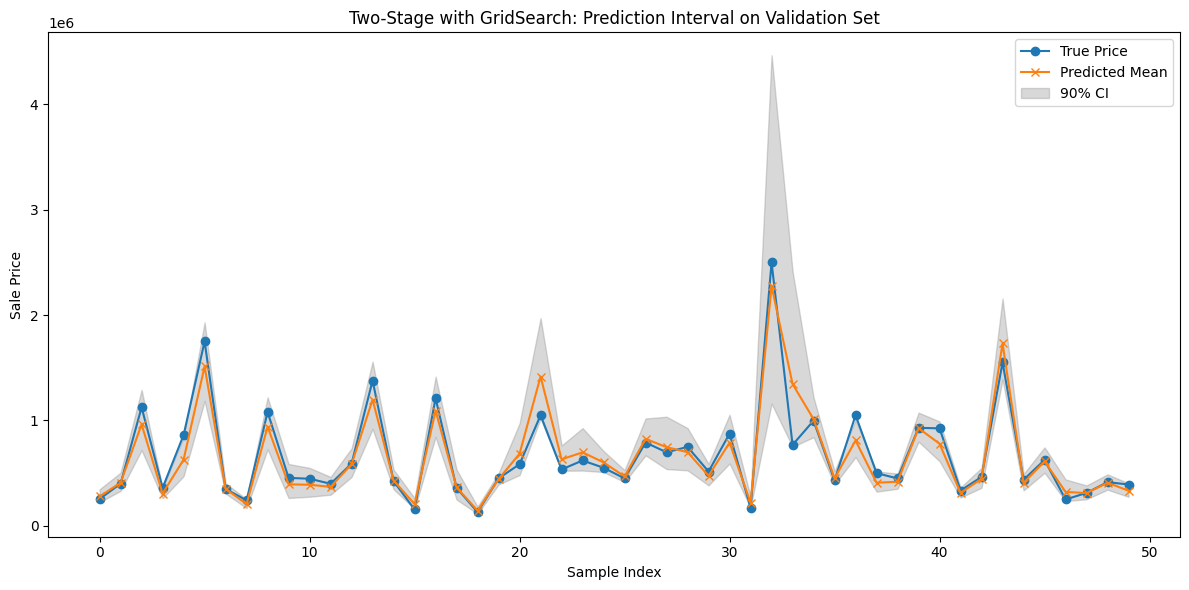

In [86]:
# ==== BIỂU ĐỒ PREDICTION INTERVAL ====
# Vẽ biểu đồ prediction interval trên tập validation
plt.figure(figsize=(12, 6))
n = 50
mu_price = np.expm1(mu_log_val)

plt.plot(y_val_real.values[:n], label="True Price", marker='o')
plt.plot(mu_price[:n], label="Predicted Mean", marker='x')
plt.fill_between(range(n), lower_val[:n], upper_val[:n], color='gray', alpha=0.3, label="90% CI")
plt.legend()
plt.title("Two-Stage with GridSearch: Prediction Interval on Validation Set")
plt.xlabel("Sample Index")
plt.ylabel("Sale Price")
plt.tight_layout()
plt.show()

- Dự đoán trung bình (đường cam) bám sát giá trị thật (đường xanh) → mô hình học tốt xu hướng.

- Khoảng dự đoán 90% (vùng mờ) bao phủ phần lớn điểm thật → ước lượng độ không chắc chắn hợp lý.

- Một số điểm có CI rất rộng → mô hình không tự tin (có thể là outlier hoặc dữ liệu hiếm).

- Một vài điểm ngoài khoảng → hợp lý do 90% CI cho phép 10% sai.